# Stochastic Gradient Descent (SGD)

In [14]:
from fastai.vision.all import *

This is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

def pr_eight(x,w): return (x*w).sum()

Here we are assuming that *x* is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector *w*. If we have this function, then we just need some way to update the weights to make them a little bit better.

Here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
2. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
3. Based on these predictions, calculate how good the model is (*its loss*).
4. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
5. *Step* (that is, change) all the weights based on that calculation.
6. Go back to the step 2, and *repeat* the process.
7. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

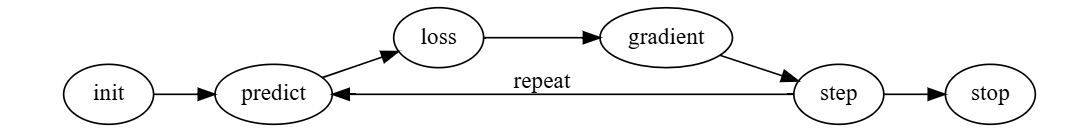

Here are a few guidelines:

1. Initialize: We initialize the parameters to random values.
2. Loss: testing the effectiveness of any current weight assignment in terms of actual performance. We need some function that will return a loss number that is small if the performance of the model is good
3. Step: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight. The way to do this is by calculating *gradients*. This is just a performance optimization
4. Stop: For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and x is a weight parameter of the function:

In [15]:
def f(x): return x**2

In [ ]:
# Here is a graph of that function:
plot_function(f, 'x', 'x**2')

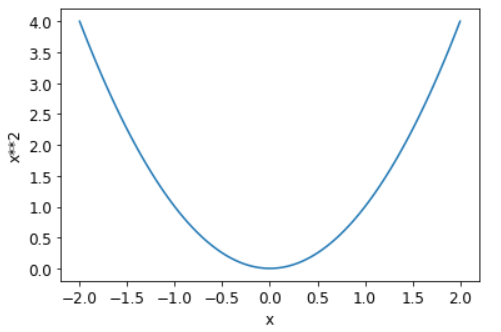

In [ ]:
# we then pick some random value for a parameter
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

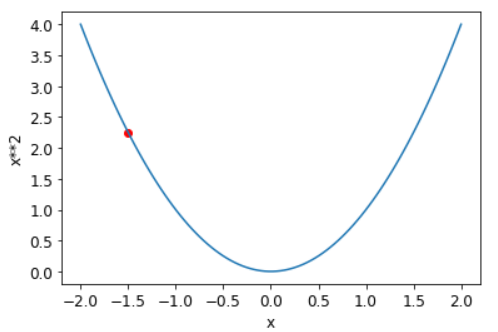

We then look to see what would happen if we increased or decreased our parameter by a little bit—the adjustment. This is simply the slope at a particular point

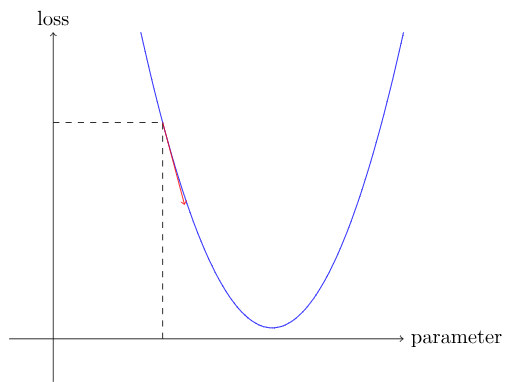

Now we look to see what would happen if we increased or decreased our parameter by a little bit—the *adjustment*. This is simply the slope at a particular point:

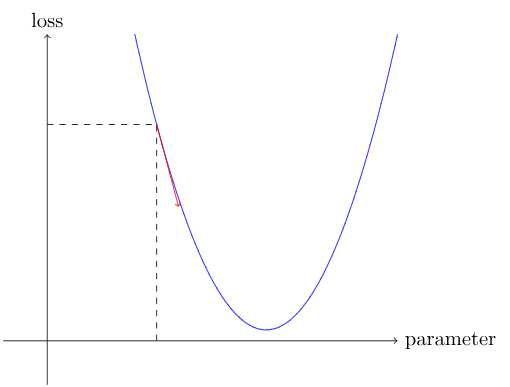

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

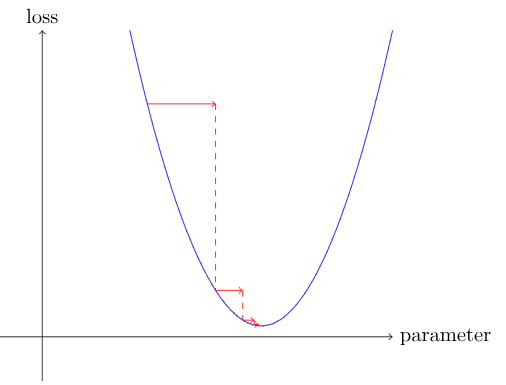

### Calculating Gradients

We use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

The derivative(dy/dx) of a function tells you how much a change in its parameters will change its result. The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

PyTorch is able to automatically compute the derivative of nearly any function. First, let's pick a tensor value which we want gradients at:

In [17]:
# This is the scalar tensor(zero dimension) with the value 3.0.
xt = tensor(3.).requires_grad_()

Notice the special method *requires_grad_*? That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value.

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated(3^2 = 9 from return function x^2), but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [18]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us:

In [19]:
yt.backward()

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. Life would probably be easier if *backward* was just called *calculate_grad*, but deep learning folks really do like to add jargon everywhere they can!

We can now view the gradients by checking the *grad* attribute of our tensor:

In [20]:
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of x**2 is 2*x, and we have x=3, or apply cahin rule(3x^2 = 6) so the gradients should be 2 * 3=6, which is what PyTorch calculated for us!

Now we'll repeat the preceding steps, but with a vector argument for our function:

In [21]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add sum to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor) (125 = 3^2 + 4^2 + 10^2):

In [22]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [24]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

### Stepping With a Learning Rate

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the *learning rate* (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Once you've picked a learning rate, you can adjust your parameters using this simple function:

w -= gradient(w) * lr

This is known as <u>*stepping*</u> your parameters, using an <u>*optimizer*</u> step. Notice how we subtract the *gradient * lr* from the parameter to update it. This allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive. We want to adjust our parameters in the direction of the slope because our goal in deep learning is to minimize the *loss*.

If you pick a learning rate that's too low, it can mean having to do a lot of steps. 

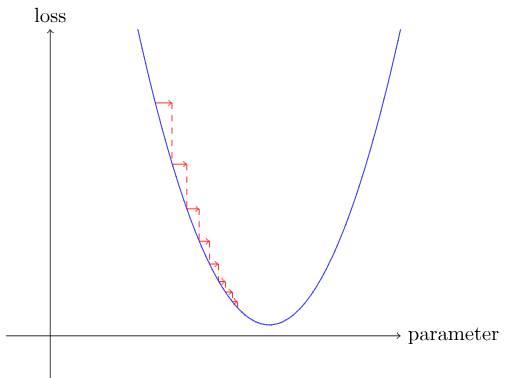

But picking a learning rate that's too high is even worse—it can actually result in the loss getting worse.

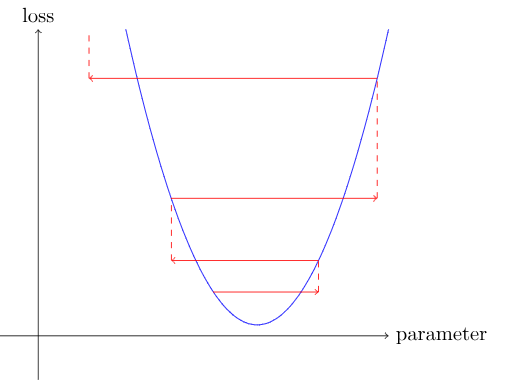

If the learning rate is too high, it may also "bounce" around, rather than actually diverging.

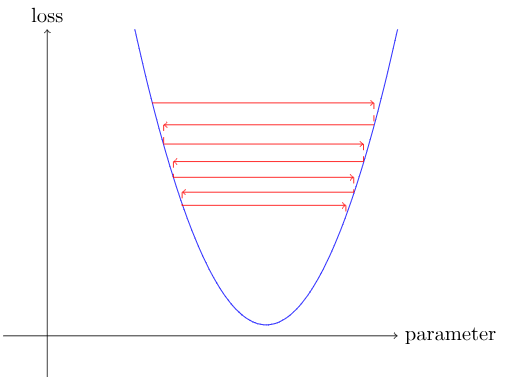